In [48]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping



In [10]:
df = pd.read_csv(r"C:/Users/varun/OneDrive/Documents/Guvi/Final Project Guvi/AAPL.csv")
df.head

<bound method NDFrame.head of             Date        Open        High         Low       Close   Adj Close  \
0     1980-12-12    0.513393    0.515625    0.513393    0.513393    0.407747   
1     1980-12-15    0.488839    0.488839    0.486607    0.486607    0.386473   
2     1980-12-16    0.453125    0.453125    0.450893    0.450893    0.358108   
3     1980-12-17    0.462054    0.464286    0.462054    0.462054    0.366972   
4     1980-12-18    0.475446    0.477679    0.475446    0.475446    0.377609   
...          ...         ...         ...         ...         ...         ...   
9818  2019-11-19  267.899994  268.000000  265.390015  266.290009  266.290009   
9819  2019-11-20  265.540009  266.079987  260.399994  263.190002  263.190002   
9820  2019-11-21  263.690002  264.010010  261.179993  262.010010  262.010010   
9821  2019-11-22  262.589996  263.179993  260.839996  261.779999  261.779999   
9822  2019-11-25  262.709991  266.440002  262.519989  266.369995  266.369995   

         

In [11]:
df.isnull().sum()

Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [12]:
# Handling missing values
df_columns =['Open','High','Low','Close','Adj Close']
df[df_columns] = df[df_columns].fillna(method='ffill')
df['Volume'] = df['Volume'].fillna(0)

C:\Users\varun\AppData\Local\Temp\ipykernel_28848\2135028903.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[df_columns] = df[df_columns].fillna(method='ffill')


In [13]:
# checking missing values
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9823 entries, 0 to 9822
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       9823 non-null   object 
 1   Open       9823 non-null   float64
 2   High       9823 non-null   float64
 3   Low        9823 non-null   float64
 4   Close      9823 non-null   float64
 5   Adj Close  9823 non-null   float64
 6   Volume     9823 non-null   float64
dtypes: float64(6), object(1)
memory usage: 537.3+ KB


In [15]:
df['Date'] = pd.to_datetime(df['Date'])


In [16]:
df.duplicated().sum()

0

In [17]:
df.shape

(9823, 7)

In [18]:
numeric_col = ['Open','High','Low','Close','Adj Close','Volume'] 
df[numeric_col] = df[numeric_col].astype(float)

In [19]:
# Useing adjusted close price only
target_col = 'Adj Close'
target_data = df[[target_col]].values 

In [20]:
target_scaler = MinMaxScaler(feature_range=(0,1))
scaled_target = target_scaler.fit_transform(target_data)

In [25]:
def create_sequences(data, window_size, forecast_horizon=1):
    X, y = [], []
    for i in range(window_size, len(data) - forecast_horizon+1):
        X.append(data[i-window_size:i, 0])
        y.append(data[i:i+forecast_horizon, 0])
    return np.array(X), np.array(y)

In [26]:
# parameter
window_size = 60
forecast_horizons = [1,5,10]
test_size = 0.2

In [30]:
# Creating dataset for each forecast horizon
results = {}
for horizon in forecast_horizons:
    X, y = create_sequences(scaled_target, window_size, horizon)

    # Split the data
    split = int(len(X) * (1 - test_size))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Reshaping for RNN/LSTM 
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],1))

    # Store dataset
    results[horizon] = {'X_train': X_train, 'X_test':X_test,
                        'y_train': y_train, 'y_test': y_test}

In [31]:
# Model building function
def train_model(X_train, y_train, X_test, y_test, horizon, units=50, dropout_rate=0.2, 
                learning_rate=0.001, batch_size=32, epochs=20):
    model = Sequential([
        LSTM(units, return_sequences=True, input_shape=(window_size, 1)),
        Dropout(dropout_rate),
        LSTM(units),
        Dropout(dropout_rate),
        Dense(horizon)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mean_squared_error')
    
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),  # Fixed typo from 'vlidation_data' to 'validation_data'
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )
    
    return model, history

In [32]:
# Train and evaluate models for each horizon
for horizon in forecast_horizons:
    print(f"\n=== Training {horizon}-day forecast model ===")
    data = results[horizon]
    
    # Train model with default parameters
    model, history = train_model(
        data['X_train'], data['y_train'],
        data['X_test'], data['y_test'],
        horizon
    )


=== Training 1-day forecast model ===


d:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - loss: 2.1740e-04 - val_loss: 6.6934e-04
Epoch 2/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 2.4819e-05 - val_loss: 2.9161e-04
Epoch 3/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 3.0942e-05 - val_loss: 3.6207e-04
Epoch 4/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 2.2876e-05 - val_loss: 9.4947e-04
Epoch 5/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 2.7157e-05 - val_loss: 0.0036
Epoch 6/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 2.3844e-05 - val_loss: 2.3272e-04
Epoch 7/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 1.8887e-05 - val_loss: 2.0510e-04
Epoch 8/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 1.8153e-05 - val_loss: 5.4946e-04
Epoch 9/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 1.7737e-05 - val_loss: 0.0027
Epoch 10/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 9.1199e-05 - val_loss: 0.0019
Epoch 11/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss

In [33]:
# Evaluate
test_loss = model.evaluate(data['X_test'], data['y_test'], verbose=0)
print(f"Test MSE: {test_loss:.4f}")

# Make prediction
predictions = model.predict(data['X_test'])

Test MSE: 0.0005
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [34]:
# Inverse transform to original scale
def inverse_transform(y_pred):
        """For any horizon, properly reshape before inverse transform"""
        if len(y_pred.shape) == 1:
            y_pred = y_pred.reshape(-1, 1)
        # Pad with zeros to match original feature count if needed
        if y_pred.shape[1] == 1:
            return target_scaler.inverse_transform(y_pred).flatten()
        else:
            # For multi-step, inverse transform each step
            result = np.zeros_like(y_pred)
            for i in range(y_pred.shape[1]):
                result[:, i] = target_scaler.inverse_transform(y_pred[:, i].reshape(-1, 1)).flatten()
            return result
    
    # Apply inverse transform
actual_prices = inverse_transform(data['y_test'])
predicted_prices = inverse_transform(predictions)

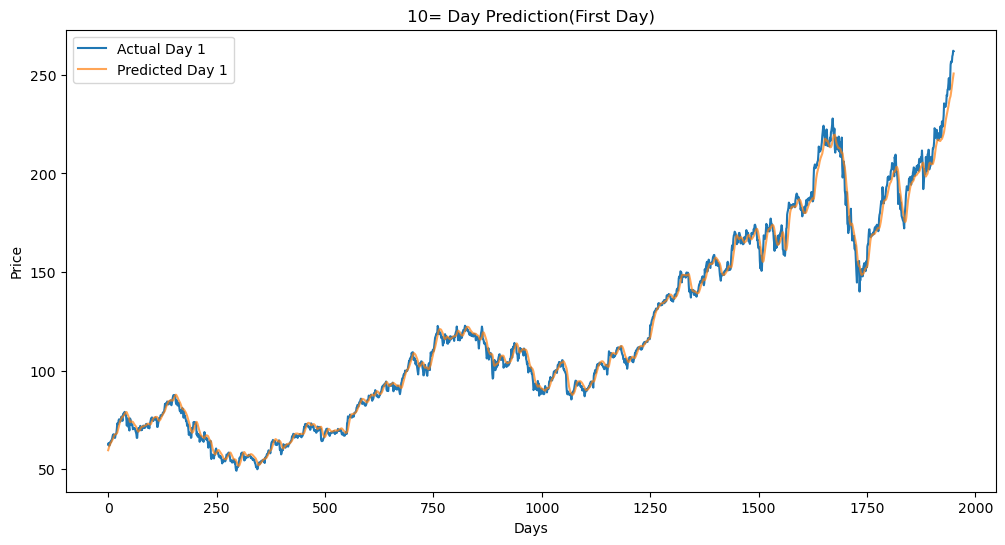

In [36]:
# Visualize first day 
plt.figure(figsize=(12,6))
if horizon == 1:
    plt.plot(actual_prices, labels='Actual')
    plt.plot(predicted_prices, label='Predicted', alpha=0.7)
else:
    plt.plot(actual_prices[:,0], label='Actual Day 1')
    plt.plot(predicted_prices[:,0], label='Predicted Day 1', alpha=0.7)
plt.title(f'{horizon}= Day Prediction(First Day)')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()



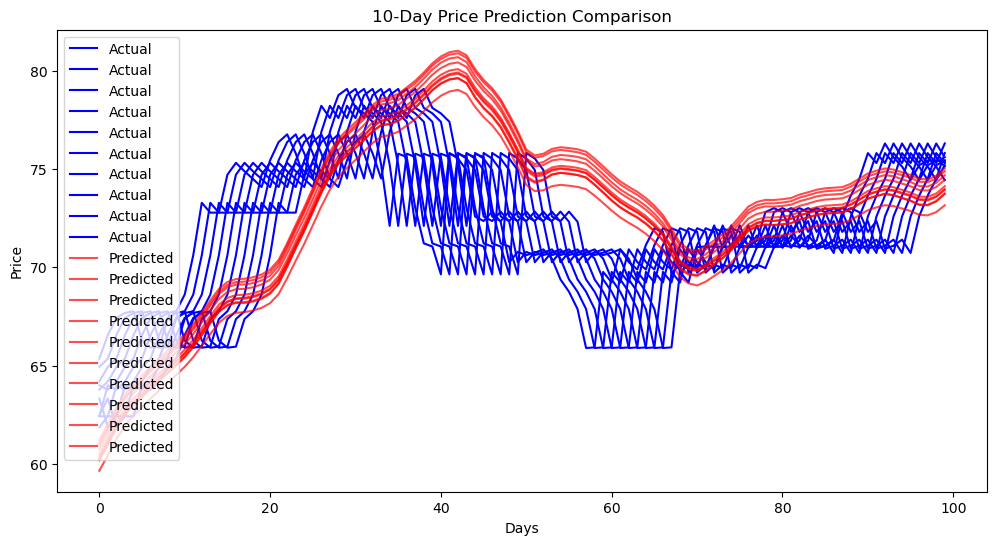

In [35]:
# Visualize first 100 days
plt.figure(figsize=(12,6))
plt.plot(actual_prices[:100], label='Actual', color='blue')
plt.plot(predicted_prices[:100], label='Predicted', color='red', alpha=0.7)
plt.title(f'{horizon}-Day Price Prediction Comparison')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

In [86]:
# Save model
model.save(f'best_model_{horizon}day.h5')
print(f"Saved {horizon}-day model")

Saved 10-day model
